In [1]:
# Attack imports
from simba import simba_attack_image
from hsja import hop_skip_jump_attack

# Helper imports
from data import CIFAR10, IMAGENETTE
import utils

# Numerical computing and display imports
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

# Other imports
import multiprocess as mp
from datetime import datetime
import logging
import os

/Users/neddamj/miniforge3/envs/nhash/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and Prepare the Data
folder_path = '../../images/'
dataset = 'imagenette'    
if dataset == 'cifar10':
    images = CIFAR10()
if dataset == 'imagenette':
    images = IMAGENETTE()
x = images.load()
images.save_to_disk(x, folder_path, num_images=100)
folder_path = utils.move_data_to_temp_ram(folder_path, ram_size_mb=50)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-09-12 15:41:45.154680: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[INFO] Images saved
[INFO] RAM Disk Already Exists...
[INFO] RAM Disk Cleared...
[INFO] Files moved to temp RAM...


In [3]:
# Threshold-hyperparameter mappings
threshold_hyperparam = {
    '1':  {'simba_hamming_threshold': 7,  'simba_l2_threshold': 20, 'hsja_l2_threshold': 16},
    '5':  {'simba_hamming_threshold': 10, 'simba_l2_threshold': 20, 'hsja_l2_threshold': 16},
    '10': {'simba_hamming_threshold': 20, 'simba_l2_threshold': 28, 'hsja_l2_threshold': 24},
    '19': {'simba_hamming_threshold': 23, 'simba_l2_threshold': 30, 'hsja_l2_threshold': 24}
}
attack_hamming_threshold = int(0.01 * 96 + 0.5) 

# SIMBA Hyperparams
simba_epsilon = 0.9
simba_hamming_threshold = threshold_hyperparam[str(attack_hamming_threshold)]['simba_hamming_threshold']                                # <= 5% - 10(max) & 10% - 20 & 20% - 23 
simba_l2_threshold = threshold_hyperparam[str(attack_hamming_threshold)]['simba_l2_threshold']
simba_max_steps = 10000 
fast = True

# HSJA Hyperparams
hsja_max_steps = 10
hsja_grad_queries = 20
hsja_l2_threshold = threshold_hyperparam[str(attack_hamming_threshold)]['hsja_l2_threshold']

# Other params
ssim_threshold = 0.8

In [4]:
# Configure logging
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H:%M:%S")
logging.basicConfig(filename='../../logs/untargeted/Eps-{simba_epsilon}_Bits-{simba_hamming_threshold}_{dt_string}.log',
                    format='%(asctime)s %(message)s',
                    level='DEBUG',
                    filemode='w',
                    force=True)
logger = logging.getLogger()
logger.info(f'Epsilon: {simba_epsilon}\tMismatched Bits Threshold: {simba_hamming_threshold}\n')

In [7]:
def joint_attack(img_path,
           epsilon, 
           logger,
           max_mismatched_bits,
           simba_l2_threshold,
           simba_max_steps,
           hsja_max_steps,
           grad_queries,
           l2_threshold,
           hamming_threshold,
           fast):
    # Prepare image path 
    
    # Soft-label attack
    (simba_filename, simba_queries) = simba_attack_image(img_path=img_path, 
                                          eps=epsilon, 
                                          logger=logger,
                                          mismatched_threshold=max_mismatched_bits, 
                                          l2_threshold=simba_l2_threshold,
                                          max_steps=simba_max_steps,
                                          fast=fast)
    # Hard-label attack
    (adv_img, hsja_queries) = hop_skip_jump_attack(orig_img_path=img_path, 
                                target_img_path=simba_filename, 
                                max_iters=hsja_max_steps, 
                                grad_queries=grad_queries, 
                                l2_threshold=l2_threshold, 
                                hamming_threshold=hamming_threshold)
    # Load the original image as well as the noisy adv. image outputted by simba
    orig_img, simba_img = utils.load_img(img_path), utils.load_img(simba_filename)
    return orig_img, simba_img, adv_img, simba_queries, hsja_queries

def attack_wrapper(idx):
    # Format the path to the input image
    img_path = f'../../images/{idx+1}.jpeg' 
    _, _, _, _, path, filetype = img_path.split('.')
    img_path = path.split('/')
    img_path = f'{folder_path}{img_path[2]}.{filetype}'

    # Attack NeuralHash 
    orig_img, simba_img, adv_img, simba_num_queries, hsja_num_queries = joint_attack(img_path, 
                                                                            simba_epsilon, 
                                                                            logger, 
                                                                            simba_hamming_threshold, 
                                                                            simba_l2_threshold,
                                                                            simba_max_steps, 
                                                                            hsja_max_steps, 
                                                                            hsja_grad_queries, 
                                                                            hsja_l2_threshold, 
                                                                            attack_hamming_threshold,
                                                                            fast)
    
    return (orig_img, simba_img, adv_img, simba_num_queries, hsja_num_queries, img_path)

In [8]:
for idx in range(5):
    p = mp.Pool(processes=4)
    results = p.map(attack_wrapper, [4*idx, 4*idx+1, 4*idx+2, 4*idx+3])
    p.close()

    for i, result in enumerate(results):
        orig_img, simba_img, adv_img, simba_num_queries, hsja_num_queries, img_path = result

        # Save the simba image and the final image
        utils.save_img(f'../../images/{4*idx+i+1}_simba.jpeg', simba_img)  
        utils.save_img(f'../../images/{4*idx+i+1}_final.jpeg', adv_img)

        # Attack Metrics
        orig_hash  = utils.compute_hash(orig_img)
        simba_hash = utils.compute_hash(simba_img)
        adv_hash = utils.compute_hash(adv_img)
        simba_hamming_dist = utils.distance(orig_hash, simba_hash, "hamming")
        final_hamming_dist = utils.distance(orig_hash, adv_hash, "hamming")
        simba_l2_dist = utils.distance(orig_img, simba_img, 'l2')
        final_l2_dist = utils.distance(orig_img, adv_img, 'l2')
        final_ssim = utils.distance(orig_img, adv_img.astype(np.uint8), 'ssim')
        total_queries = simba_num_queries + hsja_num_queries
        success = (final_hamming_dist >= attack_hamming_threshold) and (final_ssim >= ssim_threshold)

        attack_metrics = {
            'Image Path':    [img_path],
            'Success':       [success],
            'Queries':       [total_queries],
            'Simba L2':      [simba_l2_dist],
            'Final L2':      [final_l2_dist],
            'Final SSIM':    [final_ssim],
            'Simba Hamming': [simba_hamming_dist],
            'Final Hamming': [final_hamming_dist]
        }

        # Save the results
        df = pd.DataFrame.from_dict(attack_metrics)
        file_path = f'metrics/{simba_epsilon}/hamm_{attack_hamming_threshold}_l2_{hsja_l2_threshold}_{dt_string}.csv'
        if os.path.exists(file_path):
            df.to_csv(file_path, mode='a', index=False, header=False)
        else: 
            df.to_csv(file_path, index=False, header=True)


Iteration: 1 	Add Hash: 0x71363962315a474f52424e6b70417761 	Add Hamm Dist: 1 	Sub Hash: 0x71363962335a474f52424e6b70417761 	Sub Hamm Dist: 0Iteration: 1 	Add Hash: 0x7a7a4b577574684c66384b2f664d7849 	Add Hamm Dist: 0 	Sub Hash: 0x7a7a4b577574684c66384b2f664d7849 	Sub Hamm Dist: 0Iteration: 1 	Add Hash: 0x65733270776e66377735674f4b315366 	Add Hamm Dist: 0 	Sub Hash: 0x65733270776e66377735674f4b315366 	Sub Hamm Dist: 0Iteration: 1 	Add Hash: 0x667a50477874645a304e465957386645 	Add Hamm Dist: 0 	Sub Hash: 0x667a50477874645a304e465957386645 	Sub Hamm Dist: 0



Iteration: 2 	Add Hash: 0x7a7a4b577574684c66384b2f664d7849 	Add Hamm Dist: 0 	Sub Hash: 0x7a7a4b577574684c66384b2f664d7849 	Sub Hamm Dist: 0Iteration: 2 	Add Hash: 0x65733270776e66377735674f4b315366 	Add Hamm Dist: 0 	Sub Hash: 0x65733270776e66377735674f4b315366 	Sub Hamm Dist: 0Iteration: 2 	Add Hash: 0x667a50477874645a304e465957386645 	Add Hamm Dist: 0 	Sub Hash: 0x667a50477874645a304e465957386645 	Sub Hamm Dist: 0Iteration: 2 	Ad

In [ ]:
def plot_results(orig_img, simba_img, adv_img, hamming_threshold):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))
    fig.suptitle(f'Hamming Threshold: {hamming_threshold}')
    ax1.imshow(orig_img)
    ax1.set_title('Orginal Image') 
    ax2.imshow(simba_img)
    ax2.set_title('Noisy Simba Image')
    ax3.imshow(adv_img.astype(np.uint8))
    ax3.set_title('Denoised Final Image')

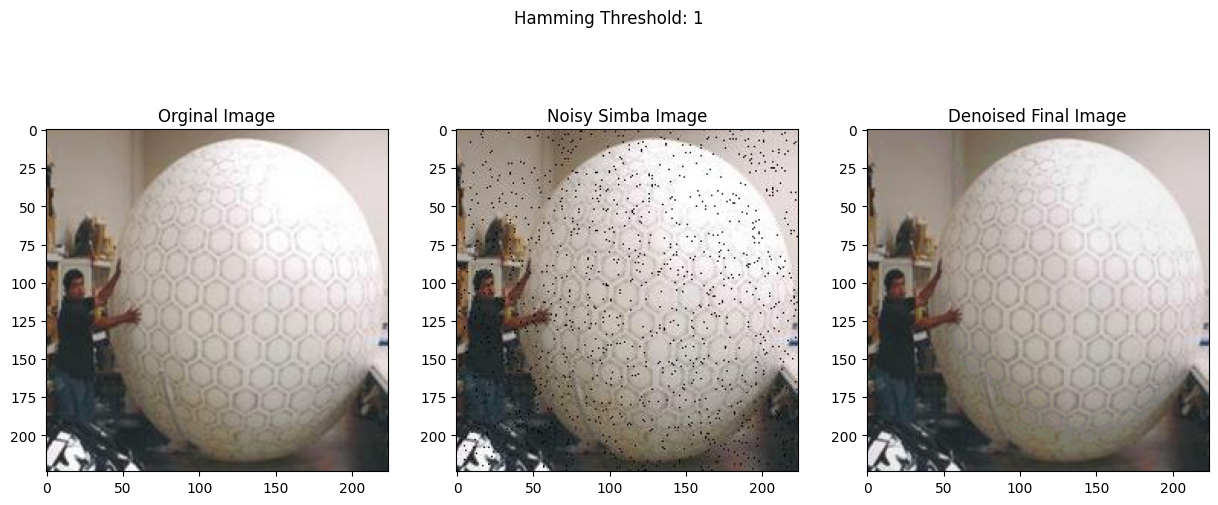

In [ ]:
# Show the images/results
plot_results(orig_img, simba_img, adv_img, attack_hamming_threshold)